Objectives:

1. understand the feedback.
2. Takle the preparing/ Data Prep.
    using log10/ train without log transformation
    include 0.1%
    take a look at the binning plot


In [1]:
import pandas as pd
import numpy as np
import os
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

/Users/dn10/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/dn10/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#from sentence_transformers import SentenceTransformer

# Path to input and output
input_path = "/Users/dn10/Downloads/Bsub_dataset/data.jsonl.gz"
output_path = "/Users/dn10/Downloads/Bsub_dataset/filtered_under_5GB.jsonl"

# Target size limit (in bytes) - 5GB
size_limit = 5 * 1024 * 1024 * 1024  # 5 GB
def truncated_jsonfile(input_path,output_path):
    # Open output file for writing
    with open(output_path, "w") as output_file:
        for chunk in pd.read_json(input_path, 
                                lines=True, 
                                compression='gzip', 
                                chunksize=100000):

            # Filter rows that contain #BSUB in 'Command' column
            filtered_chunk = chunk[chunk['Command'].str.contains('#BSUB', case=False, na=False)]

            # Write to file in JSONL format
            filtered_chunk.to_json(output_file, orient='records', lines=True)

            # Check file size after writing
            current_size = os.path.getsize(output_path)
            print(f"Written so far: {round(current_size / (1024 ** 2), 2)} MB")

            if current_size >= size_limit:
                print("File size limit reached. Stopping.")
                break
# Check if the output file exists
if os.path.exists(output_path):
    print(f"the output file {output_path} exists")
else:
    truncated_jsonfile(input_path,output_path)

the output file /Users/dn10/Downloads/Bsub_dataset/filtered_under_5GB.jsonl exists


In [10]:
df = pd.read_json("/Users/dn10/Downloads/Bsub_dataset/filtered_under_5GB.jsonl", lines=True)
len(df)

1326060

In [12]:
# Filter jobs with low memory
print(f"length of df before any filtering: {len(df)}")
df_low = df[df["MAX_MEM_USAGE_MB"] < 1.0].copy()
df_filtered = df[df["MAX_MEM_USAGE_MB"] >= 1.0].copy()
print(f"length of df after initial filtering: {len(df)}")

length of df before any filtering: 1326060
length of df after initial filtering: 1326060


In [16]:
len(df_low)

In [17]:
df_low[df_low["MAX_MEM_USAGE_MB"] == 0.0]

All the filtered rows are with memory usage of 0, therefore safe to remove

In [ ]:
# upper_bound = df_filtered["MAX_MEM_USAGE_MB"].quantile(0.999)
# print(f'{upper_bound} is the 0.999 quantile')

159099.11000000034 is the 0.999 quantile


In [23]:
df1 = df_filtered.copy()
df1['log_max_usage'] = np.log10(df_filtered["MAX_MEM_USAGE_MB"])
df1

,_id,Job_Efficiency_Percent,MEM_REQUESTED_MB,Command,MAX_MEM_USAGE_MB,NUM_EXEC_PROCS,log_max_usage
0,farm22_1744291338_63_0,24.33681,7168,#!/bin/bash;#BSUB -o /lustre/scratch125/casm/t...,387,2,2.587711
1,farm22_1744270877_986673_0,99.56010,40960,#!/bin/bash;#BSUB -o /lustre/scratch127/cellge...,1276,4,3.105851
2,farm22_1744290324_999282_0,49.05352,16384,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,8636,4,3.936313
3,farm22_1744290089_999073_0,40.50170,16384,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,8492,4,3.929010
4,farm22_1744288795_998111_0,45.76523,16384,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,11440,4,4.058426
...,...,...,...,...,...,...,...
1326055,farm22_1742937402_976002_0,79.64544,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,185,1,2.267172
1326056,farm22_1742937391_975995_0,88.19018,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,181,1,2.257679
1326057,farm22_1742937382_975992_0,99.48009,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,182,1,2.260071
1326058,farm22_1742937236_975885_0,92.76156,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,734,1,2.865696


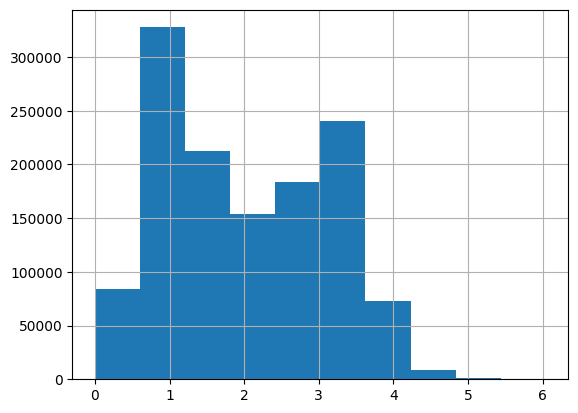

In [25]:
df1['log_max_usage'].hist()
plt.show()

The log transformed data is not as skewed and provide a good distribution for us to sample from for model training

In [ ]:
# Bin the data
df2 = df1.copy()
df2['bin'] = pd.cut(df1["log_max_usage"], bins=100)
df2

,_id,Job_Efficiency_Percent,MEM_REQUESTED_MB,Command,MAX_MEM_USAGE_MB,NUM_EXEC_PROCS,log_max_usage,bin
0,farm22_1744291338_63_0,24.33681,7168,#!/bin/bash;#BSUB -o /lustre/scratch125/casm/t...,387,2,2.587711,"(2.538, 2.598]"
1,farm22_1744270877_986673_0,99.56010,40960,#!/bin/bash;#BSUB -o /lustre/scratch127/cellge...,1276,4,3.105851,"(3.082, 3.142]"
2,farm22_1744290324_999282_0,49.05352,16384,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,8636,4,3.936313,"(3.928, 3.988]"
3,farm22_1744290089_999073_0,40.50170,16384,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,8492,4,3.929010,"(3.928, 3.988]"
4,farm22_1744288795_998111_0,45.76523,16384,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,11440,4,4.058426,"(4.049, 4.109]"
...,...,...,...,...,...,...,...,...
1326055,farm22_1742937402_976002_0,79.64544,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,185,1,2.267172,"(2.236, 2.296]"
1326056,farm22_1742937391_975995_0,88.19018,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,181,1,2.257679,"(2.236, 2.296]"
1326057,farm22_1742937382_975992_0,99.48009,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,182,1,2.260071,"(2.236, 2.296]"
1326058,farm22_1742937236_975885_0,92.76156,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,734,1,2.865696,"(2.84, 2.9]"


In [36]:
# Sample from each bin
df3 = (df2
        .groupby('bin')
        .apply(lambda x: x.sample(min(len(x),1000), random_state=42))
        .drop(columns=['bin', 'log_max_usage'])
        .reset_index(drop=True)
        )
df3

/var/folders/3n/75w52pzd50ldkh9wvq611h3c0000gq/T/ipykernel_1227/1236632346.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df3 = (df2
/var/folders/3n/75w52pzd50ldkh9wvq611h3c0000gq/T/ipykernel_1227/1236632346.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df3 = (df2


,_id,Job_Efficiency_Percent,MEM_REQUESTED_MB,Command,MAX_MEM_USAGE_MB,NUM_EXEC_PROCS
0,farm22_1743815745_602372_0,5.78157,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/casm/t...,1,1
1,farm22_1744210842_955836_0,3.74973,1024,#!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...,1,1
2,farm22_1743817460_603861_0,2.29569,1024,#!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...,1,1
3,farm22_1743705461_221976_0,1.15497,1024,#!/bin/bash;#BSUB -o /lustre/scratch127/pam/te...,1,1
4,farm22_1743742767_425321_0,0.49487,1024,#!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...,1,1
...,...,...,...,...,...,...
69643,farm22_1743458300_776035_11,98.78026,600000,#!/bin/bash;#BSUB -q normal;#BSUB -G team152;#...,581253,1
69644,farm22_1743458300_776035_5,99.15815,600000,#!/bin/bash;#BSUB -q normal;#BSUB -G team152;#...,575441,1
69645,farm22_1743458300_776035_44,99.07639,600000,#!/bin/bash;#BSUB -q normal;#BSUB -G team152;#...,599837,1
69646,farm22_1743458300_776035_31,99.04912,600000,#!/bin/bash;#BSUB -q normal;#BSUB -G team152;#...,586736,1


In [83]:
df3

,_id,Job_Efficiency_Percent,MEM_REQUESTED_MB,Command,MAX_MEM_USAGE_MB,NUM_EXEC_PROCS
0,farm22_1743815745_602372_0,5.78157,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/casm/t...,1,1
1,farm22_1744210842_955836_0,3.74973,1024,#!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...,1,1
2,farm22_1743817460_603861_0,2.29569,1024,#!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...,1,1
3,farm22_1743705461_221976_0,1.15497,1024,#!/bin/bash;#BSUB -o /lustre/scratch127/pam/te...,1,1
4,farm22_1743742767_425321_0,0.49487,1024,#!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...,1,1
...,...,...,...,...,...,...
69643,farm22_1743458300_776035_11,98.78026,600000,#!/bin/bash;#BSUB -q normal;#BSUB -G team152;#...,581253,1
69644,farm22_1743458300_776035_5,99.15815,600000,#!/bin/bash;#BSUB -q normal;#BSUB -G team152;#...,575441,1
69645,farm22_1743458300_776035_44,99.07639,600000,#!/bin/bash;#BSUB -q normal;#BSUB -G team152;#...,599837,1
69646,farm22_1743458300_776035_31,99.04912,600000,#!/bin/bash;#BSUB -q normal;#BSUB -G team152;#...,586736,1


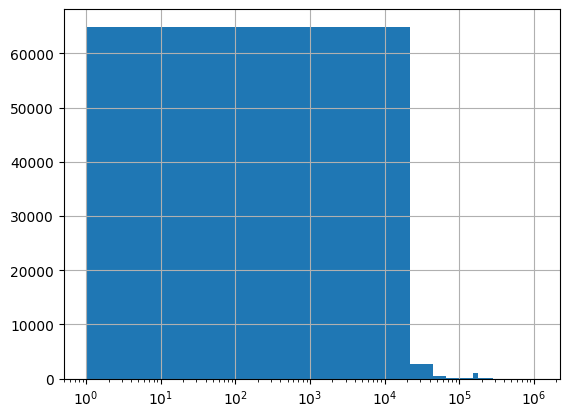

In [39]:
df3["MAX_MEM_USAGE_MB"].hist(bins=50)
plt.xscale('log')
plt.show()

Downsampling our data has been completed here.

We saved the downsampled dataset into a temporary variable
    
The data now looks evenly distributed with some outliers at the end which we kept to understand their behaviour during training.
    


In [91]:
df2

,_id,Job_Efficiency_Percent,MEM_REQUESTED_MB,Command,MAX_MEM_USAGE_MB,NUM_EXEC_PROCS,log_max_usage,bin
0,farm22_1744291338_63_0,24.33681,7168,#!/bin/bash;#BSUB -o /lustre/scratch125/casm/t...,387,2,2.587711,"(2.538, 2.598]"
1,farm22_1744270877_986673_0,99.56010,40960,#!/bin/bash;#BSUB -o /lustre/scratch127/cellge...,1276,4,3.105851,"(3.082, 3.142]"
2,farm22_1744290324_999282_0,49.05352,16384,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,8636,4,3.936313,"(3.928, 3.988]"
3,farm22_1744290089_999073_0,40.50170,16384,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,8492,4,3.929010,"(3.928, 3.988]"
4,farm22_1744288795_998111_0,45.76523,16384,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,11440,4,4.058426,"(4.049, 4.109]"
...,...,...,...,...,...,...,...,...
1326055,farm22_1742937402_976002_0,79.64544,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,185,1,2.267172,"(2.236, 2.296]"
1326056,farm22_1742937391_975995_0,88.19018,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,181,1,2.257679,"(2.236, 2.296]"
1326057,farm22_1742937382_975992_0,99.48009,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,182,1,2.260071,"(2.236, 2.296]"
1326058,farm22_1742937236_975885_0,92.76156,1024,#!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...,734,1,2.865696,"(2.84, 2.9]"


In [77]:
#Saving the df2
df2_index = df2.index.to_list()
#pd.Series(df2_index,index=df2_index).to_json("/Users/dn10/Downloads/Bsub_dataset/df_without_downsampling.jsonl", index=False)


In [ ]:
import json
with open('/Users/dn10/Downloads/Bsub_dataset/df_without_downsampling.json','w')as f:
    json.dump(df2_index, f)


In [79]:
with open('/Users/dn10/Downloads/Bsub_dataset/df_without_downsampling.json', 'r') as f:
    df4 = pd.Index(json.load(f))


In [80]:
index_from_json = df.loc[df4]

In [81]:
print(index_from_json.head())
len(index_from_json)

                          _id  Job_Efficiency_Percent  MEM_REQUESTED_MB  \
0      farm22_1744291338_63_0                24.33681              7168   
1  farm22_1744270877_986673_0                99.56010             40960   
2  farm22_1744290324_999282_0                49.05352             16384   
3  farm22_1744290089_999073_0                40.50170             16384   
4  farm22_1744288795_998111_0                45.76523             16384   

                                             Command  MAX_MEM_USAGE_MB  \
0  #!/bin/bash;#BSUB -o /lustre/scratch125/casm/t...               387   
1  #!/bin/bash;#BSUB -o /lustre/scratch127/cellge...              1276   
2  #!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...              8636   
3  #!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...              8492   
4  #!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...             11440   

   NUM_EXEC_PROCS  
0               2  
1               4  
2               4  
3               4  
4   

1286631

In [89]:
df3.to_json('/Users/dn10/Downloads/Bsub_dataset/df_with_downsampling.json', orient='records', lines=True)

In [90]:
df5 = pd.read_json('/Users/dn10/Downloads/Bsub_dataset/df_with_downsampling.json', lines= True)
print(df5.head())
len(df5)

                          _id  Job_Efficiency_Percent  MEM_REQUESTED_MB  \
0  farm22_1743815745_602372_0                 5.78157              1024   
1  farm22_1744210842_955836_0                 3.74973              1024   
2  farm22_1743817460_603861_0                 2.29569              1024   
3  farm22_1743705461_221976_0                 1.15497              1024   
4  farm22_1743742767_425321_0                 0.49487              1024   

                                             Command  MAX_MEM_USAGE_MB  \
0  #!/bin/bash;#BSUB -o /lustre/scratch126/casm/t...                 1   
1  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   
2  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   
3  #!/bin/bash;#BSUB -o /lustre/scratch127/pam/te...                 1   
4  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   

   NUM_EXEC_PROCS  
0               1  
1               1  
2               1  
3               1  
4   

69648